# Classify the 10 digits using MNIST data

Implement a convolutional neural network using `NumPy`ONLY to classify the digits. 

## Data Description
[MNIST](https://en.wikipedia.org/wiki/MNIST_database)

# 1. Data Extraction and Preprocessing

### 1.1 Data Extraction

In [1]:
# load the mnist data
from sklearn.datasets import fetch_openml
import numpy as np

In [2]:
mnist_28 = fetch_openml('mnist_784', parser = 'auto') #fetch the mnist_784 dataset using the fetch_openml API and store it in a variable 

In [1]:
#mnist_28 #visualize the data stored in the variable

In [27]:
mnist_28_img= mnist_28.data.to_numpy() #Convert the 'data' key in the dataset into a numpy array
#The mnist_28.data consists of 784-pixel values 

In [28]:
mnist_28_img.shape #The shape of the numpy array 

(70000, 784)

In [7]:
#let us display one image from the data set
import matplotlib.pyplot as plt

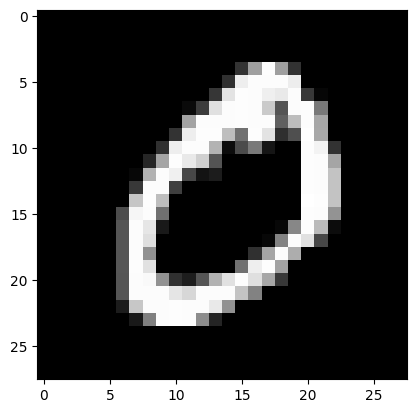

In [8]:
plt.imshow((mnist_28_img[1]).reshape(28,28), cmap=plt.cm.gray) #inorder to display the image, we have to convert the 1-D array into a
# a matrix of 28 by 28

### 1.2 Tasks  

1) Data Pre-Processing

 - Reshaping each row in (28, 28) shaped array
 - Splitting the data set into training and testing sets
 - One-hot Encoding for the classification

2) Defining Function classes for CNN

 - Linear Layer
 - ReLU Layer
 - Softmax activation With Cross Entropy Loss
 - 2D - Convolution
 - 2D Max Pooling
 - Stochastic Gradient Descent Optimization

3) Training and Testing Model



### 1.3 Data Preprocessing - Split and Reshape

In [29]:
# Split the dataset and reshape the images
X_train = mnist_28_img[0:60000][:].reshape(-1, 28, 28, 1) #The train data set
X_test = mnist_28_img[60000:][:].reshape(-1, 28, 28, 1) #The test data set

In [30]:
#Print the shapes of the X-values of the train and test data
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (60000, 28, 28, 1)
X_test shape: (10000, 28, 28, 1)


In [34]:
# Convert labels to numpy array and then to integers
mnist_28_labels = mnist_28.target.to_numpy().astype(int)

# Split the labels
y_train = mnist_28_labels[0:60000]
y_test = mnist_28_labels[60000:]


In [35]:
# Print the shapes of the y-values or the target variable of the train and test data sets.
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (60000,)
y_test shape: (10000,)


### 1.4 One-Hot Encoding

In [36]:
'''
One-hot encoding of labels helps represent categorical variables as binary vectors. 
This enables the machine-learning algorithms to function directly without any bias or incompatibility.
Here, we convert each of the digits from 0 to 9 into an array of zeros and ones such that the 
position in the array where it is equal to the value will be 1 and the rest will be zero.
'''
def one_hot_encode(labels, num_classes=10):
    """ One-hot encode the labels."""
    encoded = np.zeros((labels.shape[0], num_classes))
    for idx, label in enumerate(labels):
        encoded[idx, label] = 1
    return encoded

In [37]:
# Implementing the one-hot encoding to target variable
y_train = one_hot_encode(y_train)
y_test = one_hot_encode(y_test)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (60000, 10)
y_test shape: (10000, 10)


# 2. Defining Function classes for CNN

### 2.1 Linear Layer (Fully Connected)
<p>This layer will contain weights and biases. During the forward pass, we'll compute the matrix multiplication and addition:</p>
<code>X.W + b</code>



In [38]:
#Defining the CNN components

#Linear Layer (Fully Connected Layer)

'''
Class variables
weights: These are small random values that break symmetry and speed up convergence
biases: Initially set to zero, on further movement it is updated to balance.
gradients: These are gradients with respect to weights (dw) and biases (db) initialized to None.
input variable (z): It is used to store the input for backpropagation.
Class functions
forward: enables forward propagation of linear layer by returning (X.W + b)
backward: enables backpropagation of the linear layer by returning (grad.(W.T))
'''
class Linear:
    def __init__(self, input_dim, output_dim):
        self.weights = np.random.randn(input_dim, output_dim) * 0.01
        self.biases = np.zeros((1, output_dim))
        self.dw = None
        self.db = None
        self.z = None

    def forward(self, x):
        self.z = x
        return np.dot(x, self.weights) + self.biases

    def backward(self, gradient):
        #Gradient of weights: dot product of input transposed and incoming gradient
        self.dw = np.dot(self.z.T, gradient)
        #Gradient of biases: sum the incoming gradient along axis 0 (rows)
        self.db = np.sum(gradient, axis=0, keepdims=True)
        #Compute gradient with respect to the input to pass to the previous layer
        return np.dot(gradient, self.weights.T)

### 2.2 ReLU Layer
<p>The ReLU (Rectified Linear Unit) activation function will transform input values <code>x</code> to:</p>
<code>max(0, x)</code>

In [39]:
# ReLU Layer
'''
Class variables
input: initializes the input variable to be none
Class functions
forward: Forward propagation method for ReLU activation function returning either zero or the input, whichever is the maximum
backward: Backward propagation method for ReLU activation function returning gradient * (self.input > 0)
'''
class ReLU:
    def __init__(self):
        self.input = None

    def forward(self, x):
        #Stores the input for later use in backpropagation
        self.input = x
        #Computes the element-wise maximum of 0 and input x, returning the result
        return np.maximum(0, x)

    def backward(self, gradient):
        # Computes the gradient of the ReLU activation function
        # Returns gradient * 1 if input > 0, else returns gradient * 0
        #Element-wise multiplication of incoming gradient with the ReLU gradient which is boolean array for input > 0
        return gradient * (self.input > 0)

### 2.3 Softmax Activation with Cross Entropy Loss
<p>After the final layer, we'll use a softmax function to get probability distributions for multi-class classification. The cross-entropy loss will then measure the difference between the predicted and true distributions. The formula for the softmax function for a given input <code>z</code> is:</p>
<code>softmax(z<sub>i</sub>) = exp(z<sub>i</sub>) / &Sigma; exp(z<sub>j</sub>)</code>
<p>Where the summation is over all classes. The cross-entropy loss for true labels <code>y</code> and predicted probabilities <code>p</code> is:</p>
<code>-&Sigma; y<sub>i</sub> log(p<sub>i</sub>)</code>

In [40]:
# Softmax Activation with Cross Entropy Loss for multi-class classifications
'''
Class functions
forward: computes the Softmax function for the input logits, 
        calculates probabilities by normalizing the exponentials, 
        computes the negative log-likelihood loss of the true labels under the predicted probabilities, 
        and returns the loss normalized by the batch size.
backward: computes the gradient of the Softmax Cross-Entropy loss with respect to the predicted probabilities. 
        It returns the difference between predicted probabilities and true labels, normalized by the batch size, 
        which is used during backpropagation to update the model's parameters.
'''
class SoftmaxCrossEntropy:
    def __init__(self):
        #Initializes variables to store computed probabilities and true labels
        self.probabilities = None
        self.true_labels = None

    def forward(self, logits, labels):
        #Compute exponentials of input logits after adjusting for numerical stability
        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        #Compute probabilities by normalizing the exponentials
        self.probabilities = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
        #Store true labels for later use in backpropagation
        self.true_labels = labels
        #Compute and return the loss: negative log-likelihood of the true labels under the predicted probabilities
        return -np.sum(labels * np.log(self.probabilities + 1e-15)) / logits.shape[0]

    def backward(self):
        #Compute the gradient of the loss with respect to the predicted probabilities
        #The gradient is the difference between predicted probabilities and true labels, normalized by the batch size
        return (self.probabilities - self.true_labels) / self.true_labels.shape[0]

### 2.4 2D - Convolution
<p>The convolutional layer will contain filters (or kernels) that will be convolved with the input image to detect patterns. The convolution operation for an input <code>I</code> and a filter <code>F</code> is:</p>
<code>(I &ast; F)(x, y) = &Sigma; &Sigma; I(x - i, y - j) F(i, j)</code>

In [41]:
# 2D - Convolution with backward pass (taking channels into account)
'''
Class functions
forward: performs the forward propagation for the convolutional layer, 
        computing the convolution operation between the input and the filters.
backward: performs backpropagation for the convolutional layer, 
        computing gradients for both filters and the input tensor. 
        The filters are updated using the computed gradients with a learning rate of 0.01. 
        The method returns the computed gradients for the input tensor, 
        which are used for further backpropagation through the network
'''
class Conv2D:
    def __init__(self, num_filters, filter_size, input_channels=1):
        #Initializes the convolutional layer with specified number of filters, filter size, and input channels
        self.num_filters = num_filters
        self.filter_size = filter_size
        #Initialize filters with small random values, normalized by 9 for stability
        self.filters = np.random.randn(num_filters, filter_size, filter_size, input_channels) / 9
        #Variable to store the input for later use in backpropagation
        self.input = None

    def forward(self, input):
        #Store the input for later use in backpropagation
        self.input = input
        batch_size, h, w, _ = input.shape
        #Initialize output tensor with appropriate dimensions
        output = np.zeros((batch_size, h - self.filter_size + 1, w - self.filter_size + 1, self.num_filters))

        #Perform convolution operation using the initialized filters and input
        for b in range(batch_size):
            for i in range(output.shape[1]):
                for j in range(output.shape[2]):
                    for f in range(self.num_filters):
                        #Compute the convolution operation and populate the output tensor
                        output[b, i, j, f] = np.sum(input[b, i:i+self.filter_size, j:j+self.filter_size] * self.filters[f])
        #Return the output tensor after convolution
        return output

    def backward(self, gradient):
        batch_size, h, w, num_filters = gradient.shape
        #Initialize gradients for filters and input tensor
        d_filters = np.zeros_like(self.filters)
        d_input = np.zeros_like(self.input)

        #Compute gradients for filters and input tensor during backpropagation
        for b in range(batch_size):
            for i in range(h):
                for j in range(w):
                    for f in range(num_filters):
                        #Update gradients for filters using the chain rule
                        d_filters[f] += gradient[b, i, j, f] * self.input[b, i:i+self.filter_size, j:j+self.filter_size]
                        #Update gradients for input tensor using the chain rule
                        d_input[b, i:i+self.filter_size, j:j+self.filter_size] += gradient[b, i, j, f] * self.filters[f]

        # Update the filters using the computed gradients with a learning rate of 0.01
        self.filters -= 0.01 * d_filters

        #Return the computed gradients for the input tensor, which will be used for further backpropagation
        return d_input

# This class now assumes a single channel (grayscale) for the input by default.


### 2.5 2D Max Pooling
<p>Max pooling will downsample the input based on the maximum value in a region. For a given region <code>R</code> in the input:</p>
<code>max_pool(R) = max(R)</code>

In [42]:
# 2D Max Pooling with backward pass
'''
Class functions
forward: performs max pooling on the input, reducing the dimensions by selecting the 
        maximum value within non-overlapping regions.
backward: computes gradients for the input tensor during backpropagation. 
        It uses the max values computed during forward propagation and assigns the incoming gradient to the 
        location of the maximum value, propagating it back to the corresponding input region.
'''
class MaxPooling2D:
    def __init__(self, pool_size=2):
        #Initializes the max pooling layer with a specified pool size
        self.pool_size = pool_size
        #Variable to store the input for later use in backpropagation
        self.input = None

    def forward(self, input):
        #Store the input for later use in backpropagation
        self.input = input
        batch_size, h, w, num_filters = input.shape
        #Initialize output tensor with reduced dimensions after pooling
        output = np.zeros((batch_size, h // self.pool_size, w // self.pool_size, num_filters))

        #Perform max pooling operation on input
        for b in range(batch_size):
            for i in range(0, h, self.pool_size):
                for j in range(0, w, self.pool_size):
                    #Extract the region of interest and find the maximum value in the region
                    output[b, i//self.pool_size, j//self.pool_size] = np.amax(input[b, i:i+self.pool_size, j:j+self.pool_size], axis=(0, 1))
        #Return the output tensor after max pooling
        return output

    def backward(self, gradient):
        batch_size, h, w, num_filters = gradient.shape
        #Initialize gradients for the input tensor
        d_input = np.zeros_like(self.input)

        #Compute gradients for input tensor during backpropagation
        for b in range(batch_size):
            for i in range(0, h * self.pool_size, self.pool_size):
                for j in range(0, w * self.pool_size, self.pool_size):
                    for f in range(num_filters):
                        #Extract the region of interest
                        region = self.input[b, i:i+self.pool_size, j:j+self.pool_size, f]
                        max_val = np.amax(region)
                        #Create a mask of the region with the max value
                        mask = (region == max_val)
                        #Update gradients for input tensor using the mask and incoming gradient
                        d_input[b, i:i+self.pool_size, j:j+self.pool_size, f] += mask * gradient[b, i//self.pool_size, j//self.pool_size, f]
        #Return the computed gradients for the input tensor, which will be used for further backpropagation
        return d_input


### 2.6 Stochastic Gradient Descent (SGD) Optimization
<p>SGD will be used to update the weights based on the gradients computed during backpropagation. The weight update rule is:</p>
<code>W<sub>new</sub> = W<sub>old</sub> - &alpha; &times; dW</code>
<p>Where <code>&alpha;</code> is the learning rate and <code>dW</code> is the gradient of the loss with respect to the weights.</p>


In [43]:
#Stochastic Gradient Descent (SGD) Optimization
'''
Class function
update: performs parameter updates for a given layer using the gradients (dw for weights and db for biases) 
        computed during backpropagation. It adjusts the weights and biases in the opposite direction of the gradients, 
        scaled by the learning rate, in order to minimize the loss function during training.
'''
class SGD:
    def __init__(self, lr=0.01):
        #Initializes the SGD optimizer with a learning rate (default is 0.01)
        self.lr = lr

    def update(self, layer):
        #Update weights and biases of the given layer using the computed gradients and learning rate
        layer.weights -= self.lr * layer.dw
        layer.biases -= self.lr * layer.db

# 3. Training and Testing

### 3.1 Creating the model.

In [44]:
#Combining all the layers into a single CNN model class.
'''
Class functions
forward: performs forward propagation through the model, including convolution, activation, pooling, flattening, and fully connected layer operations. 
        It computes and returns the loss using Softmax Cross-Entropy loss function.
backward: performs backward propagation through the model. It starts by computing gradients using the Softmax Cross-Entropy loss function, 
        then backpropagates through the fully connected layer, reshapes the gradient, 
        and further backpropagates through the max pooling layer, ReLU activation, and convolutional layer. 
        The gradients are used to update the parameters of the model during training.
'''
class MnistCNN:
    def __init__(self):
        #Initializes the layers and components of the CNN model for MNIST digit classification
        #Convolutional layer with 8 filters and a filter size of 3x3
        self.conv = Conv2D(num_filters=8, filter_size=3)
        #Max pooling layer with a pool size of 2x2
        self.pool = MaxPooling2D(pool_size=2)
        #Fully connected (dense) layer with 10 output units (for 10 classes)
        self.fc = Linear(13*13*8, 10)
        #ReLU activation function
        self.relu = ReLU()
        #Softmax Cross-Entropy loss activation function for classification
        self.loss_activation = SoftmaxCrossEntropy()

    def forward(self, x, labels):
        #Perform convolution, ReLU activation, max pooling, and flattening
        x = self.conv.forward(x)
        x = self.relu.forward(x)
        x = self.pool.forward(x)
        x = x.reshape(x.shape[0], -1)  # Flatten
        #Perform forward propagation through the fully connected layer
        x = self.fc.forward(x)
        #Compute the loss using Softmax Cross-Entropy activation function
        loss = self.loss_activation.forward(x, labels)
        #Return the computed loss
        return loss

    def backward(self):
        #Compute gradients using Softmax Cross-Entropy loss function
        gradient = self.loss_activation.backward()
        #Backpropagate through the fully connected layer and reshape the gradient
        gradient = self.fc.backward(gradient)
        gradient = gradient.reshape(-1, 13, 13, 8)  # Reshape back to match pooling layer shape
        #Backpropagate through the max pooling layer, ReLU activation, and convolutional layer
        gradient = self.pool.backward(gradient)
        gradient = self.relu.backward(gradient)
        gradient = self.conv.backward(gradient)
        #Not returning anything, as the gradients update the parameters during backpropagation

### 3.2 Training the CNN model

In [45]:
#Create an instance of the MnistCNN model
model = MnistCNN()
#Instantiate Stochastic Gradient Descent (SGD) optimizer with a learning rate of 0.01v
optimizer = SGD(lr=0.01)
num_epochs = 5 #Number of epochs (complete passes through the dataset)
batch_size = 250 #Batch size for training data

#Loop through each epoch for training
for epoch in range(num_epochs):
    #Iterate through the training data in batches
    for i in range(0, len(X_train), batch_size):
        #Extract a batch of input samples and their corresponding labels
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        #Forward pass: compute the loss for the current batch
        loss = model.forward(batch_X, batch_y)

        #Backward pass: compute gradients and update model parameters
        model.backward()

        #Update the fully connected layer's weights using SGD
        optimizer.update(model.fc)

    #Print loss for the current epoch
    print(f"Epoch {epoch+1}, Loss: {loss}")

Epoch 1, Loss: 0.13859506146674858
Epoch 2, Loss: 0.12858069986739087
Epoch 3, Loss: 0.1244833985020946
Epoch 4, Loss: 0.12431455666813777
Epoch 5, Loss: 0.12578034587651382


### 3.3 Testing the model 

<b>By testing the model, we find the accuracy of the model in classifying the digits in the MNIST dataset</b>

In [46]:
#Initialize a variable to keep track of the number of correct predictions
correct_predictions = 0
#Iterate through the test dataset
for i in range(len(X_test)):
    # Reshape the test image to include a batch dimension (1, 28, 28, 1)
    test_image = X_test[i].reshape(1, 28, 28, 1)

    #Perform forward pass through the convolutional, ReLU, and max pooling layers
    pooled_output = model.pool.forward(model.relu.forward(model.conv.forward(test_image)))

    # Flatten the output of the pooling layer
    flattened_output = pooled_output.reshape(pooled_output.shape[0], -1)

    #Perform forward pass through the fully connected layer to get logits
    logits = model.fc.forward(flattened_output)
    #Compute the predicted class (index with the highest logit score)
    prediction = np.argmax(logits)
    #Get the true label from the one-hot encoded target vector
    true_label = np.argmax(y_test[i])
    #Check if the prediction matches the true label
    if prediction == true_label:
        correct_predictions += 1

#Calculate accuracy by dividing the number of correct predictions by the total number of test samples
accuracy = correct_predictions / len(X_test)
#Print the test accuracy percentage
print(f"Test accuracy: {accuracy*100:.2f}%")


Test accuracy: 96.44%


# Conclusion
- In this implementation, a Convolutional Neural Network (CNN) model for classifying handwritten digits from the MNIST dataset was developed and trained. 
- The model architecture consists of a convolutional layer followed by ReLU activation, max-pooling, and a fully connected layer with softmax activation for multiclass classification.
- The model was trained using the Stochastic Gradient Descent (SGD) optimizer over 5 epochs with a batch size of 250.
### Training and testing of the model
- During training, the model learned to recognize intricate patterns and features in the input images, enabling it to make accurate predictions.
- The training process involved iterative forward and backward passes, adjusting the model's parameters to minimize the softmax cross-entropy loss.
- After the training process, the model demonstrated a high level of accuracy on the unseen test dataset, achieving an accuracy of 96.44%.

<b>This high test accuracy indicates the effectiveness of the CNN architecture and the optimization techniques used.</b>